In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns
init_notebook_mode(connected=True)
import random
import math
import scipy.stats as ss

In [2]:
#Some Global Constants
categorical = 'categorical'
numerical = 'numerical'
categorical_null_val = 'None'

In [3]:
def get_col_datatype_util(col_datatype):
    return dict( [(col,str) if val==categorical else (col,float) for col,val in col_datatype.items()])

In [4]:
def get_col_datatype():
    col_datatype = {"partner_id":categorical,"domain_name":categorical,"country_code":categorical,"creative_id":categorical,"canonical_hash":categorical,"keyword_strategy_used":categorical,"browser_id":categorical,"device_id":categorical,"os_id":categorical,"metro_code":categorical,"url_category_id":categorical,"hour_id":categorical}

    return col_datatype

In [5]:
def get_col_default(df):
    return dict([(col,categorical_null_val) if val==categorical else (col,round(df[col].mean(),2)) for col,val in get_col_datatype().items()])

## Read DataFrame

In [6]:
df = pd.read_csv(r"C:\Users\nishant.da\Downloads\nishant_dayal_visible_data\\data.csv",
                 dtype = get_col_datatype_util(get_col_datatype()))
df.head(10)

,partner_id,domain_name,country_code,creative_id,canonical_hash,keyword_strategy_used,browser_id,device_id,os_id,metro_code,url_category_id,hour_id,visible_impression,impression
0,7PRFT79UO,13wham.com,US,166664156,a252dc44c032756d1a23eb6d7158b9db.d2s,224,16,3,6,555,86266,11,0,74
1,7PRFT79UO,2018060212.dummyimpression.log,IN,198994822,3477bb4d529c020ef3de377a04456d45.d2s,70,40,0,10,635,NaN,00,0,7714
2,7PRFT79UO,247wallst.com,US,354835382,dfce2f6077e1b771f7103cdffcc33023.d2s,180,6,3,6,505,8165,12,0,13
3,7PRFT79UO,247wallst.com,US,389657298,173f14cffe4c222a56d2a5e6758e808d.d2s,NaN,6,4,6,807,NaN,17,0,11
4,7PRFT79UO,247wallst.com,US,389657298,226b4f67c33fe41c89cd43cc45d9858b.d2s,NaN,5,4,1,501,NaN,14,1,18
5,7PRFT79UO,247wallst.com,US,389657298,2828bde3bc134c1f34137eb14a13cd0e.d2s,135,14,4,1,881,126127,06,0,37
6,7PRFT79UO,247wallst.com,US,389657298,9380800b07690fc7ec9854a5cb485047.d2s,135,6,4,6,807,90422,17,1,13
7,7PRFT79UO,247wallst.com,US,389657298,d87c30a425e3dac95dc117250a88725b.d2s,135,5,4,1,803,8165,23,1,10
8,7PRFT79UO,247wallst.com,US,389657298,fc42c0e4e913dd55ec17a5d3fee91019.d2s,NaN,5,4,1,501,108325,22,0,10
9,7PRFT79UO,247wallst.com,US,567875254,64565b7a6560a052f161c2971becd7df.d2s,224,5,4,1,511,89238,12,0,10


## Global Constants

In [7]:
target_col = "visible_impression"
weight_col = "impression"

In [8]:
#Global Constants
misc_percent = 0.005
misc_col_value = 'Others'
col_datatype = get_col_datatype()
col_default = get_col_default(df)

In [9]:
if weight_col is None:
    weight_col='weight'
    df[weight_col] = 1

In [10]:
def get_features(df):
    return [x for x in list(df.columns) if x not in [target_col,weight_col]]
    
def get_categorical_cols():
    return [x for x,v in col_datatype.items() if v==categorical]
    
def get_numerical_cols():
    return [x for x,v in col_datatype.items() if v==numerical]

In [11]:
def random_colors(num_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(num_of_colors)]
    return color
    
def make_copy_df(df):
    return df.copy()
    
def get_total(df,col):
    return df[col].sum()
    
def fill_default_values(df):
    for c in get_features(df):
        df[c].fillna(col_default.get(c),inplace=True)
    return df
    
def return_top_k(df,col,top_k):
    temp_df = df.sort_values(by=col,ascending=False)
    return temp_df[:top_k]

In [12]:
#Unique Values DataFrame
def unique_count(df):
    feature_col = 'Features'
    count_col = 'Unique Count'
    unique_count_df = pd.DataFrame(columns=[feature_col,count_col])
    
    unique_count_df[feature_col] = get_categorical_cols()
    unique_count_df[count_col] = unique_count_df[feature_col].apply(lambda col: df[col].nunique())
    
    return unique_count_df

## Unique Count DataFrame

In [13]:
unique_count_df = unique_count(df)
unique_count_df

,Features,Unique Count
0,partner_id,9
1,domain_name,7014
2,country_code,225
3,creative_id,9534
4,canonical_hash,228958
5,keyword_strategy_used,106
6,browser_id,25
7,device_id,7
8,os_id,12
9,metro_code,1231


In [14]:
# This function returns the dataframe subset and fill NULL values with some other value
def make_group(df,col,weight_col,fill_na=False,reset_index=True):
    temp_df = pd.DataFrame(df[col+[weight_col]])
    
    if fill_na:
        temp_df = fill_default_values(temp_df)
    
    group = temp_df.groupby(col).agg({weight_col:'sum'})
    
    if reset_index:
        group = group.reset_index()
    
    return group

In [15]:
def do_miscing(df,col,weight_col,misc_percent):
    group = make_group(df,[col],weight_col)

    if_misc_col = 'if_misc'
    group[if_misc_col]=False
    
    summation = get_total(df,weight_col)*misc_percent*0.01
    
    group[if_misc_col] = group[weight_col].apply(lambda x:True if x<summation else False)
    group[col] = group.apply(lambda x:misc_col_value if x[if_misc_col] else x[col],axis=1)
    
    misced_group = make_group(group,[col],weight_col)
    return misced_group

In [16]:
def is_feature_irrelevant(df,col,weight_col,misc_percent):    
    fin_group = do_miscing(df,col,weight_col,misc_percent)
    fin_group = fin_group[(fin_group[col]!=col_default.get(col)) & (fin_group[col]!=misc_col_value)]
    
    return fin_group.empty

In [17]:
def get_irrelevant_features(df,weight_col,misc_precent):
    irrelevant_cols=[]
    
    for col in get_features(df):
        if df[col].nunique()==df.shape[0]:
            irrelevant_cols.append(col)
        elif is_feature_irrelevant(df,col,weight_col,0.05):
            irrelevant_cols.append(col)
            
    return irrelevant_cols

In [18]:
def remove_irrelevant_features(df,weight_col,misc_percent):
    irrelevant_features = get_irrelevant_features(df,weight_col,misc_percent)
    df.drop(irrelevant_features,axis=1,inplace=True)
    return df

## Remove Irrelevant Features

In [19]:
df = remove_irrelevant_features(df,weight_col,misc_percent)

In [20]:
def make_misced_df(df,target_col,weight_col):
    df = make_copy_df(df)
    df = fill_default_values(df)
    
    misced_df = pd.DataFrame(columns = list(df.columns))
    misced_df[target_col] = df[target_col]
    misced_df[weight_col] = df[weight_col]
    
    for col in get_categorical_cols():
        misced_group = do_miscing(df,col,weight_col,misc_percent)
        unique_values = set(misced_group[col].unique())
        misced_df[col] = df[col].apply(lambda x: x if (x in unique_values) else misc_col_value)
    
    for col in get_numerical_cols():
        misced_df[col] = df[col]
        
    return misced_df

## Misced DataFrame

In [21]:
misced_df = make_misced_df(make_copy_df(df),target_col,weight_col)
misced_df.head()

,partner_id,domain_name,country_code,creative_id,canonical_hash,keyword_strategy_used,browser_id,device_id,os_id,metro_code,url_category_id,hour_id,visible_impression,impression
0,7PRFT79UO,13wham.com,US,166664156,a252dc44c032756d1a23eb6d7158b9db.d2s,224,16,3,6,555,86266,11,0,74
1,7PRFT79UO,2018060212.dummyimpression.log,IN,198994822,3477bb4d529c020ef3de377a04456d45.d2s,70,40,0,10,635,None,00,0,7714
2,7PRFT79UO,247wallst.com,US,Others,Others,180,6,3,6,505,Others,12,0,13
3,7PRFT79UO,247wallst.com,US,389657298,173f14cffe4c222a56d2a5e6758e808d.d2s,None,6,4,6,807,None,17,0,11
4,7PRFT79UO,247wallst.com,US,389657298,226b4f67c33fe41c89cd43cc45d9858b.d2s,None,5,4,1,501,None,14,1,18


In [22]:
def get_bar_trace(x,y,name=''):
    return go.Bar(x = x,y = y,name = name,opacity=0.6)

In [23]:
def plot_bar_chart(x,y,title):
    trace = get_bar_trace(x,y)
    data = [trace]
    layout = go.Layout(title=title,xaxis=dict(type='category'))
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

In [24]:
def calculate_missing_count(df,col,weight_col):
    temp_df = df[df[col].isnull()][weight_col]
    return temp_df.sum()

In [25]:
#Missing Values Plot (Count and Ratio)
def missing_values_plot(df,weight_col):
    feature_col = 'Features'
    count_col = 'Count'
    ratio_col = 'Ratio'
    
    missing = pd.DataFrame(columns=[feature_col,count_col,ratio_col])
    
    missing[feature_col]=get_features(df)
    missing[count_col] = missing[feature_col].apply(lambda col: calculate_missing_count(df,col,weight_col))
    
    total_weight = get_total(df,weight_col)
    
    missing[ratio_col] = missing[count_col].apply(lambda x:x/total_weight) 
    missing.sort_values(by=count_col,ascending=False,inplace=True)
    
    plot_bar_chart(missing[feature_col],missing[count_col],'Missing Count')
    plot_bar_chart(missing[feature_col],missing[ratio_col],'Missing Ratio')

## Missing Count and Ratio

In [26]:
missing_values_plot(make_copy_df(df),weight_col)

## Plotting Functions

In [27]:
def set_plt_params(width,height,title,xlabel,ylabel):
    plt.rcParams["figure.figsize"] = [width,height]
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [28]:
def plot_pie_chart(labels,values,title):
    data = [go.Pie(
        labels=labels,
        values=values,
        marker=dict( colors = random_colors(len(labels)) ),
        textfont=dict( size = 20 )
    )]    
    layout = go.Layout(title = title)
    
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

In [29]:
def pie_chart(df,col,weight_col,top_k):
    title = col
    
    group = make_group(df,[col],weight_col)
    group_top_k = return_top_k(group,weight_col,top_k)
    
    set_values = set(group_top_k[col])
    group[col] = group[col].apply(lambda x:misc_col_value if x not in set_values else x)
    
    group = make_group(group,[col],weight_col)
    
    plot_pie_chart(group[col],group[weight_col],title)

In [30]:
def get_value(df,val,col,weight_col):
    index = df[weight_col].searchsorted(val)
    ret_df = df.iloc[index].reset_index()
    
    return (ret_df.iloc[0][col])

In [31]:
def append_first_and_third_quartile(arr,df,total_len,factor,col,weight_col):
    if ((total_len+1)%4)==0:
        arr.append(get_value(df,(total_len+1)*factor,col,weight_col))
    else:
        arr.append((get_value(df,math.ceil((total_len+1)*factor),col,weight_col)+get_value(df,math.floor((total_len+1)*factor),col,weight_col))/2)

In [32]:
def quartiles(df,col,weight_col):
    df = make_copy_df(df)
    df.sort_values(by=col,inplace=True)
    df.reset_index()
    df[weight_col] = df[weight_col].cumsum()
    
    total_len = df.iloc[df.shape[0]-1][weight_col]
    arr = list()
    
    arr.append(df.iloc[0][col])
    append_first_and_third_quartile(arr,df,total_len,1/4,col,weight_col)
    
    if total_len%2==1:
        arr.append((get_value(df,total_len/2,col,weight_col)+get_value(df,(total_len/2)+1,col,weight_col))/2)
    else:
        arr.append(get_value(df,(total_len+1)/2,col,weight_col))
    
    append_first_and_third_quartile(arr,df,total_len,3/4,col,weight_col)
    arr.append(df.iloc[df.shape[0]-1][col])
    
    return arr

In [33]:
def remove_outliers(df,col,weight_col):
    quar = quartiles(df,col,weight_col)
    iqr_range = quar[3]-quar[1]
    
    df = df[df[col]>(quar[1]-1.5*iqr_range)]
    df = df[df[col]<(quar[3]+1.5*iqr_range)]
    
    return df

In [34]:
def hist_plot(df,col,weight_col,nbins):
    title = col
    
    temp_df = df[[col,weight_col]]
    temp_df = fill_default_values(temp_df)
    temp_df = remove_outliers(temp_df,col,weight_col)

    set_plt_params(20,15,title,col,'Weight')
    plt.hist(temp_df[col],bins=nbins,weights=temp_df[weight_col])
    plt.show()

In [35]:
def weight_plot(df,col,weight_col):
    for c in col:
        if col_datatype.get(c)==categorical:
            pie_chart(df,c,weight_col,100)
        elif col_datatype.get(c)==numerical:
            hist_plot(df,c,weight_col,100)

In [36]:
def plot_group_bar_chart(df,col,target_col,weight_col,title,top_k):
    df_target_one = df[df[target_col]==1]
    df_target_zero = df[df[target_col]==0]

    trace_target_zero = get_bar_trace(df_target_zero[col],df_target_zero[weight_col],'Not Visible')
    trace_target_one = get_bar_trace(df_target_one[col],df_target_one[weight_col],'Visible')

    data = [trace_target_zero,trace_target_one]
    layout = go.Layout(barmode='group',title=title,xaxis=dict(type='category'))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [37]:
def get_topk_feature_value(df,col,target_col,weight_col,top_k):
    group_with_weight = return_top_k(make_group(df,[col],weight_col),weight_col,top_k)
    
    group_with_target_and_weight = make_group(df,[col,target_col],weight_col)
    
    group = group_with_target_and_weight[group_with_target_and_weight[col].isin(group_with_weight[col])]
    group = group[(group[col]!=col_default.get(col)) & (group[col]!=misc_col_value)]
    
    return group

In [38]:
# BarPlot of the classes of a category for Visible and Not Visible Target
def bar_plot(df,col,target_col,weight_col,top_k):
    title_name = col
    
    group = get_topk_feature_value(df,col,target_col,weight_col,top_k)
    
    plot_group_bar_chart(group,col,target_col,weight_col,title_name,top_k)

In [39]:
def hist_plot_target(df,col,target_col,weight_col,nbins):
    title = col

    temp_df = df[[col,target_col,weight_col]]
    temp_df = fill_default_values(temp_df)
    temp_df = remove_outliers(temp_df,col,weight_col)
    
    temp_df_target_one = temp_df[temp_df[target_col]==1]
    temp_df_target_zero = temp_df[temp_df[target_col]==0]

    set_plt_params(12,9,'Hist 0/1',col,'Weight')
    plt.hist(temp_df_target_zero[col], bins=nbins, alpha=0.5, label='0',weights=temp_df_target_zero[weight_col])
    plt.hist(temp_df_target_one[col], bins=nbins, alpha=0.5, label='1',weights=temp_df_target_one[weight_col])
    plt.legend(loc='upper right')
    plt.show()

In [40]:
def weight_plot_target(df,col,target_col,weight_col):
    for c in col:
        if col_datatype.get(c)==categorical:
            bar_plot(df,c,target_col,weight_col,100)
        elif col_datatype.get(c)==numerical:
            hist_plot_target(df,c,target_col,weight_col,100)

In [41]:
def get_avg_values(df,col,target_col,weight_col,top_k):
    group = get_topk_feature_value(df,col,target_col,weight_col,top_k)  
    columns = set(group[col].unique())
    
    group = group.set_index([col,target_col])
    group = group.to_dict()
    
    values = dict()
    for i in columns:
        val1 = group.get(weight_col).get((i,0)) if group.get(weight_col).get((i,0)) is not None else 0
        val2 = group.get(weight_col).get((i,1)) if group.get(weight_col).get((i,1)) is not None else 0
        values[i] = 0 if val2==0 else val2/(val1+val2)

    values.pop(col_default.get(col),None)
    values.pop(misc_col_value,None)
    
    return values

In [42]:
#Plot the Encoded Value of each feature value in a feature
def avg_val_bar_plot(df,col,target_col,weight_col,top_k):
    values = get_avg_values(df,col,target_col,weight_col,top_k)
    
    sorted_values = sorted(values.items(), key=lambda kv: kv[1],reverse=True)
    sorted_x = [x[0] for x in sorted_values]
    sorted_y = [x[1] for x in sorted_values]
    
    plot_bar_chart(sorted_x,sorted_y,'Percentage Plot : '+str(col))

In [43]:
def dist_plot(df,col,weight_col,nbins):
    title = col

    temp_df = df[[col,weight_col]]
    temp_df = fill_default_values(temp_df)
    temp_df = remove_outliers(temp_df,col,weight_col)

    ax = sns.distplot(temp_df[col],kde=True,bins=nbins,
                 hist_kws={'weights': temp_df[weight_col]})
    ax.set(xlabel=col, ylabel='PDF Value',title=title)
    plt.show()

In [44]:
def average_value_plot(df,col,target_col,weight_col):
    for c in col:
        if col_datatype.get(c)==categorical:
            avg_val_bar_plot(df,c,target_col,weight_col,500)
        elif col_datatype.get(c)==numerical:
            dist_plot(df,c,weight_col,100)

In [45]:
def box_plot_util(df,title,col,weight_col,group_col=None):
    df = make_copy_df(df)
    data = []
    
    if group_col==None:
        arr = quartiles(df,col,weight_col)
        arr.insert(int(len(arr)/2),arr[int(len(arr)/2)])
        data.append(go.Box(y=arr))
    else:
        for c in df[group_col].unique():
            arr = quartiles(df[df[group_col]==c],col,weight_col)
            arr.insert(int(len(arr)/2),arr[int(len(arr)/2)])
            data.append(go.Box(y=arr,name=c))
    
    layout = go.Layout(title = title)
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [46]:
def box_plot(df,columns,weight_col,col_datatype,group_col=None):
    for col in columns:
        if col_datatype.get(col)==numerical:
            box_plot_util(df,'Box Plot',col,weight_col,group_col)

## Mean Encoding

In [47]:
#Creating Numerical DF
def cat_to_numerical_TBS(col,prior,default_val,group,weight_col,include_na=True):
    if (include_na) & (col==default_val):
        return None
    
    weight_target_zero = group.get(weight_col).get((col, 0)) if group.get(weight_col).get((col, 0)) is not None else 0
    weight_target_one = group.get(weight_col).get((col, 1)) if group.get(weight_col).get((col, 1)) is not None else 0
    
    summation = weight_target_zero + weight_target_one + 1
    
    retval = (weight_target_one+prior)/summation
    return retval

vectorized_cat_to_numerical_TBS = np.vectorize(cat_to_numerical_TBS)

In [48]:
def calculate_prior(df,target_col,weight_col):
    group = make_group(df,[target_col],weight_col,reset_index=False).to_dict()
    prior = group.get(weight_col).get(1)/((group.get(weight_col).get(0)+group.get(weight_col).get(1)))
    return prior

In [49]:
def make_numerical_df(df,target_col,weight_col,include_na=True):
    df = make_copy_df(df)
    df = fill_default_values(df)
    
    numerical_df = pd.DataFrame(columns = list(df.columns))
    numerical_df[target_col] = df[target_col]
    numerical_df[weight_col] = df[weight_col]
    
    prior = calculate_prior(df,target_col,weight_col)
    
    for col in get_categorical_cols():
        group = make_group(df,[col,target_col],weight_col,reset_index=False).to_dict()
        default_val = col_default.get(col)
        numerical_df[col] = vectorized_cat_to_numerical_TBS(df[col],prior,default_val,group,weight_col,include_na)
    
    for col in get_numerical_cols():
        numerical_df[col] = df[col]
        
    return numerical_df

In [50]:
numerical_df_without_na = make_numerical_df(misced_df,target_col,weight_col,False)

## Weight of Evidence Encoding

In [51]:
def cat_to_numerical_WOE(col,prior_zero,prior_one,default_val,group,weight_col,total_zero,total_one,capval,include_na=True):
    if (include_na) & (col==default_val):
        return None
    
    weight_target_zero = group.get(weight_col).get((col, 0)) if group.get(weight_col).get((col, 0)) is not None else 0
    weight_target_one = group.get(weight_col).get((col, 1)) if group.get(weight_col).get((col, 1)) is not None else 0
    
    retval = math.log(((weight_target_one+prior_one)/total_one)/((weight_target_zero+prior_zero)/total_zero))

    if retval>capval:
        retval = capval
    elif retval<(-capval):
        retval = -capval
        
    return retval

vectorized_cat_to_numerical_WOE = np.vectorize(cat_to_numerical_WOE)

In [52]:
def calculate_prior_WOE(df,target_col,weight_col):
    prior_one = (df[df[target_col]==1][weight_col]).sum()/df[weight_col].sum()
    prior_zero = (df[df[target_col]==0][weight_col]).sum()/df[weight_col].sum()
    return (prior_zero,prior_one)

In [53]:
def make_woe_df(df,target_col,weight_col,include_na=True):
    df = make_copy_df(df)
    df = fill_default_values(df)
    
    woe_df = pd.DataFrame(columns = list(df.columns))
    woe_df[target_col] = df[target_col]
    woe_df[weight_col] = df[weight_col]
    
    prior_zero,prior_one = calculate_prior_WOE(df,target_col,weight_col)
    total_one = df[df[target_col]==1][weight_col].sum()
    total_zero = df[df[target_col]==0][weight_col].sum()
    
    for col in get_categorical_cols():
        group = make_group(df,[col,target_col],weight_col,reset_index=False).to_dict()
        default_val = col_default.get(col)
        woe_df[col] = vectorized_cat_to_numerical_WOE(df[col],prior_zero,prior_one,default_val,group,weight_col,total_zero,total_one,10,include_na)
    
    for col in get_numerical_cols():
        woe_df[col] = df[col]
        
    return woe_df

## Weight of Evidence DataFrame

In [54]:
woe_df = make_woe_df(misced_df,target_col,weight_col,False)

## Logistic Regression

In [55]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

In [56]:
def weighted_mean(df,col, weight_col):
    return (df[col]*df[weight_col]).sum()/df[weight_col].sum()

In [57]:
def weighted_std(df,columns,weight_col):
    den = get_total(df,weight_col)
    std_list = list()
    
    for col in columns:
        mean = weighted_mean(df,col,weight_col)
        diff = (df[col]-mean)**2
        diff = diff*df[weight_col]
        std_list.append(math.sqrt(diff.sum()/den))
        
    return std_list

In [58]:
def get_coeff_df(df,model,columns):
    coeff_df = pd.DataFrame(columns=['col','coeff','std','Coefficient'])
    coeff_df['coeff'] = list(model.coef_[0])
    coeff_df['col'] = columns
    coeff_df['std'] = weighted_std(df,columns,weight_col)
    coeff_df['Coefficient'] = abs(coeff_df['coeff']*coeff_df['std'])
    coeff_df = coeff_df.sort_values(by='Coefficient',ascending=False)
    coeff_df.drop(['coeff','std'],axis=1,inplace=True)
    return coeff_df

In [59]:
def fit_logistic_regression_model(df,target_col,weight_col,columns=None,reg=False,c=1):
    train_df = make_copy_df(df)
    
    target = train_df[target_col]
    train_df.drop([target_col],axis=1,inplace=True)
    weight = train_df[weight_col]
    train_df.drop([weight_col],axis=1,inplace=True)
    
    if columns is not None:
        train_df.drop(columns,axis=1,inplace=True)
    
    if reg:
        model = LogisticRegression(penalty='l1',C=c,verbose=1)
    else:
        model = LogisticRegression(verbose=1)
        
    model.fit(train_df,target,sample_weight=weight)
    
    train_df[target_col] = df[target_col]
    train_df[weight_col] = df[weight_col]
    coeff_df = get_coeff_df(train_df,model,get_features(train_df))
    
    return (model,coeff_df)

In [60]:
logistic_model,coeff_df = fit_logistic_regression_model(numerical_df_without_na,target_col,weight_col,['os_id'],True,0.005)

[LibLinear]

## Coefficient DataFrame

In [61]:
coeff_df

,col,Coefficient
3,creative_id,1.912781
4,canonical_hash,0.524524
7,device_id,0.459252
1,domain_name,0.438554
2,country_code,0.251388
6,browser_id,0.246982
5,keyword_strategy_used,0.130342
0,partner_id,0.084822
8,metro_code,0.066347
9,url_category_id,0.028991


In [62]:
def fit_logistic_regression_model_woe(df,target_col,weight_col,columns=None,reg=False,c=1):
    train_df = make_copy_df(df)
    
    target = train_df[target_col]
    train_df.drop([target_col],axis=1,inplace=True)
    weight = train_df[weight_col]
    train_df.drop([weight_col],axis=1,inplace=True)
    
    if columns is not None:
        train_df.drop(columns,axis=1,inplace=True)
    
    if reg:
        model = LogisticRegression(penalty='l1',C=c,verbose=1)
    else:
        model = LogisticRegression(verbose=1)
        
    model.fit(train_df,target,sample_weight=weight)
    
    train_df[target_col] = df[target_col]
    train_df[weight_col] = df[weight_col]
    coeff_df = pd.DataFrame(columns=['col','Coefficient'])
    coeff_df['col'] = get_features(train_df)
    coeff_df['Coefficient'] = abs(model.coef_[0])
    coeff_df.sort_values(by='Coefficient',inplace=True,ascending=False)
    
    return (model,coeff_df)

In [63]:
logistic_model_woe,coeff_df_woe = fit_logistic_regression_model_woe(woe_df,target_col,weight_col,None,True,0.005)

[LibLinear]

## Coefficient DataFrame(Using WOE Encoded Data)

In [64]:
coeff_df_woe

,col,Coefficient
3,creative_id,0.810483
8,os_id,0.442922
4,canonical_hash,0.227722
6,browser_id,0.163717
2,country_code,0.157136
1,domain_name,0.107492
7,device_id,0.077571
5,keyword_strategy_used,0.068011
11,hour_id,0.042194
10,url_category_id,0.037942


## XGBoost Implementation

In [65]:
#XGBoost Implementation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,plot_importance,plot_tree
import graphviz

In [137]:
# Plotting Feature Importance
def plot_feature_importance(model,importance_type):
    plt.rcParams["figure.figsize"] = [12,9]
    plot_importance(model,importance_type=importance_type)
    plt.show()

In [67]:
# Plotting Tree Models
def plot_and_save_boosted_trees(model,num_of_trees,filename,width,height):
    plt.rcParams["figure.figsize"] = [width,height]

    i=0
    for i in range(num_of_trees):
        plot_tree(model,num_trees=i)
        plt.savefig(filename+str(i)+".png",dpi=150)
        plt.show()

In [136]:
def get_important_features(model):
    features_importance = model.get_booster().get_score(importance_type='cover')
    sorted_features_importance = sorted(features_importance.items(), key=lambda kv: kv[1],reverse=True)
    
    ret_list = list()
    for i in range(len(sorted_features_importance)):
        ret_list.append(sorted_features_importance[i][0])
    
    return ret_list

In [69]:
def fit_xgboost_model(df,target_col,weight_col):
    df = make_copy_df(df)
    
    target = df[target_col]
    df.drop([target_col],axis=1,inplace=True)
    weight = df[weight_col]
    df.drop([weight_col],axis=1,inplace=True)
    
    model = XGBClassifier(max_depth=5,learning_rate=0.02,n_estimators=100,booster='gbtree',missing=None,silent=False)
    model.fit(df,target,sample_weight=weight)
    
    return model

In [70]:
numerical_df = make_numerical_df(misced_df,target_col,weight_col,True)

In [71]:
xgboost_model = fit_xgboost_model(numerical_df,target_col,weight_col)

In [128]:
imp_feature_list_xgboost = get_important_features(xgboost_model)

## Feature Importance(XGBoost)

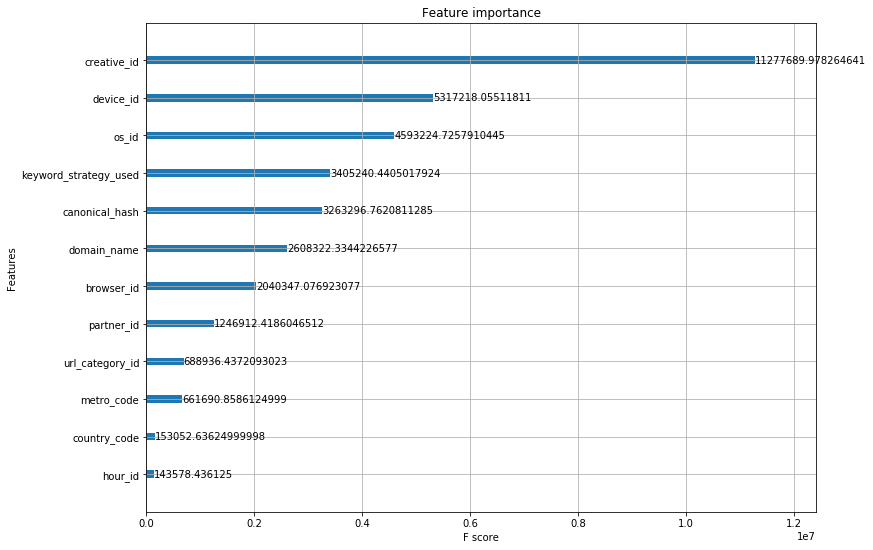

In [138]:
plot_feature_importance(xgboost_model,'cover')

## Trained Trees

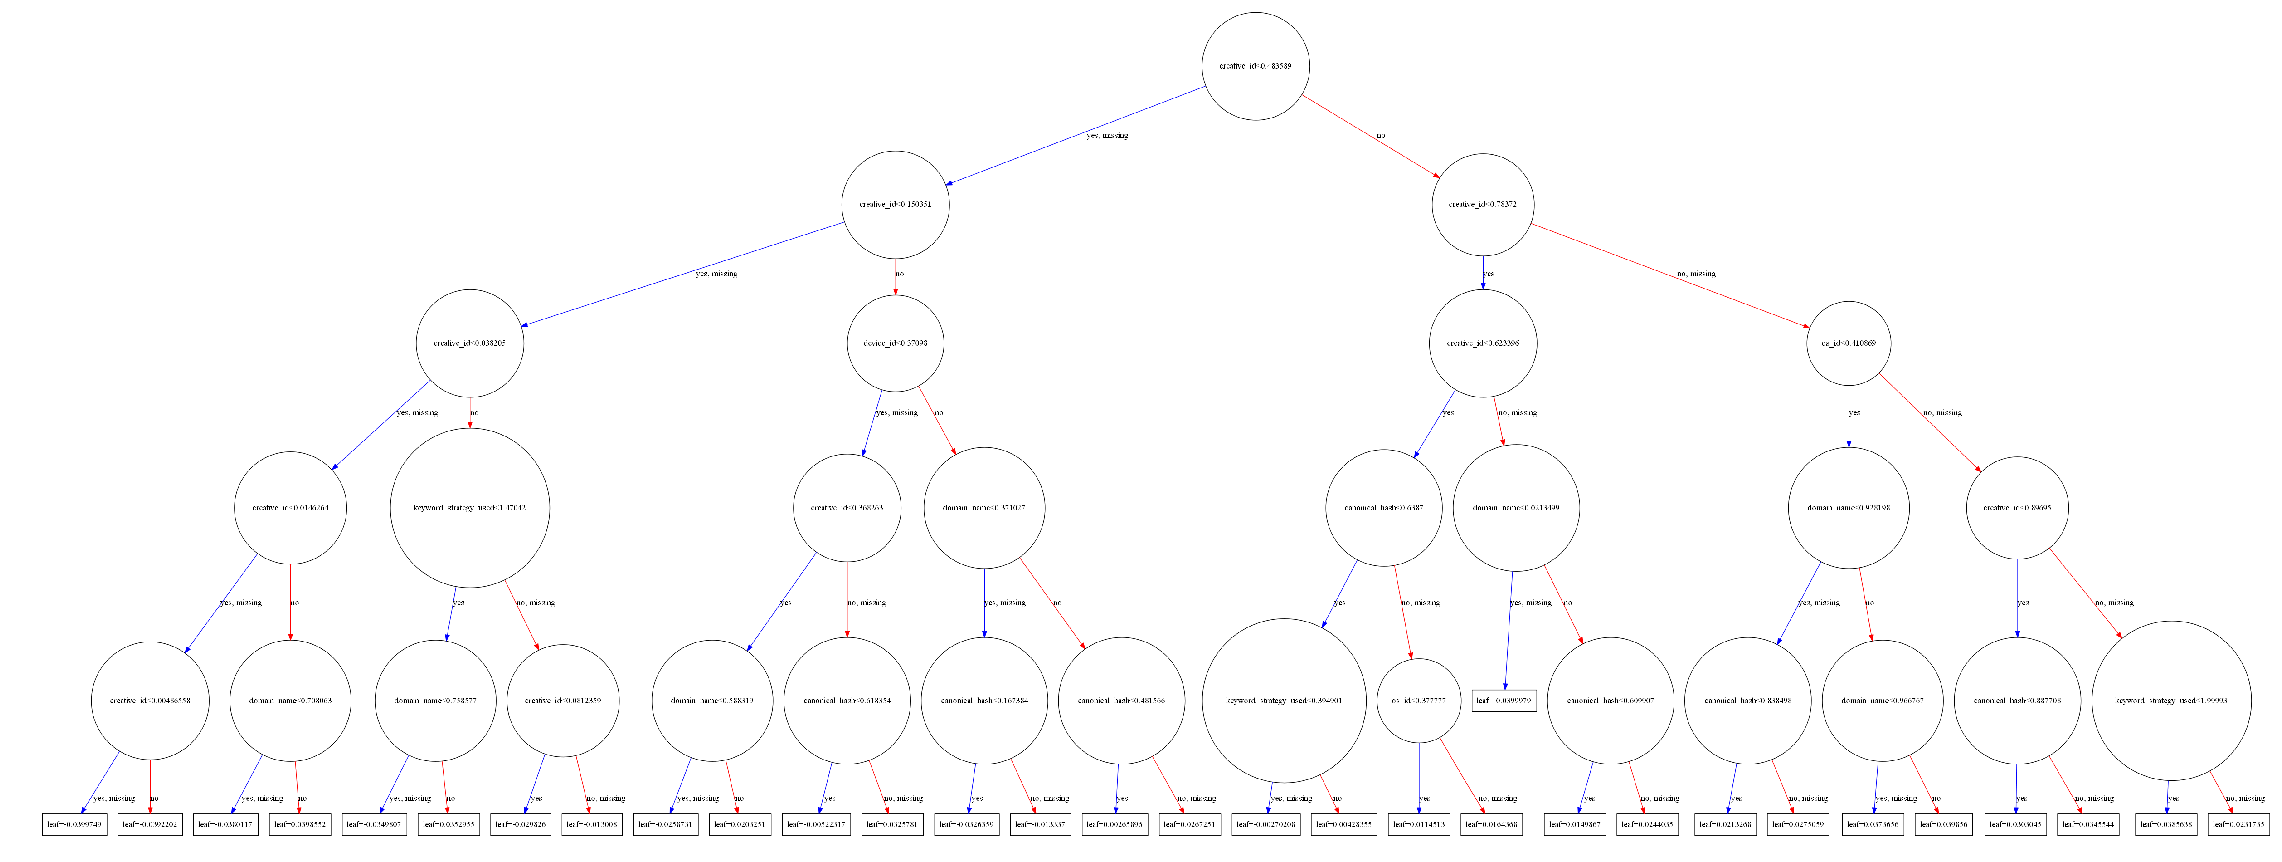

In [74]:
plot_and_save_boosted_trees(xgboost_model,1,'final_xgboost_tree',40,30)

## LightGBM Implementation

In [75]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [76]:
def label_encode_data(df):
    df = make_copy_df(df)
    
    list_le = dict()
    for col in get_features(df):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        list_le[col] = le
        
    return df,list_le

In [77]:
label_encoded_df,list_le = label_encode_data(misced_df)

In [78]:
def plot_feature_importance_lightgbm(model):
    plt.rcParams["figure.figsize"] = [12,9]
    lgb.plot_importance(model,importance_type='gain')
    plt.show()

In [79]:
def get_important_features_lightgbm(df,model):
    ret_list = list(zip(list(df.columns),lightgbm_model.booster_.feature_importance(importance_type='gain')))
    
    return [x[0] for x in sorted(ret_list, key=lambda x: x[1],reverse=True)]

In [123]:
def fit_lightgbm_model(df,target_col,weight_col):
    df = make_copy_df(df)
    
    target = df[target_col]
    df.drop([target_col],axis=1,inplace=True)
    weight = df[weight_col]
    df.drop([weight_col],axis=1,inplace=True)
    
    model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=20,
                               max_depth=5,learning_rate=0.01,objective='binary',n_estimators=100, max_cat_threshold = 500)
    
    model.fit(df,target,sample_weight=weight,categorical_feature=get_categorical_cols())
    
    return model

In [124]:
lightgbm_model = fit_lightgbm_model(label_encoded_df,target_col,weight_col)

In [125]:
imp_feature_list_lightgbm = get_important_features_lightgbm(misced_df,lightgbm_model)

## Feature Importance LightGBM

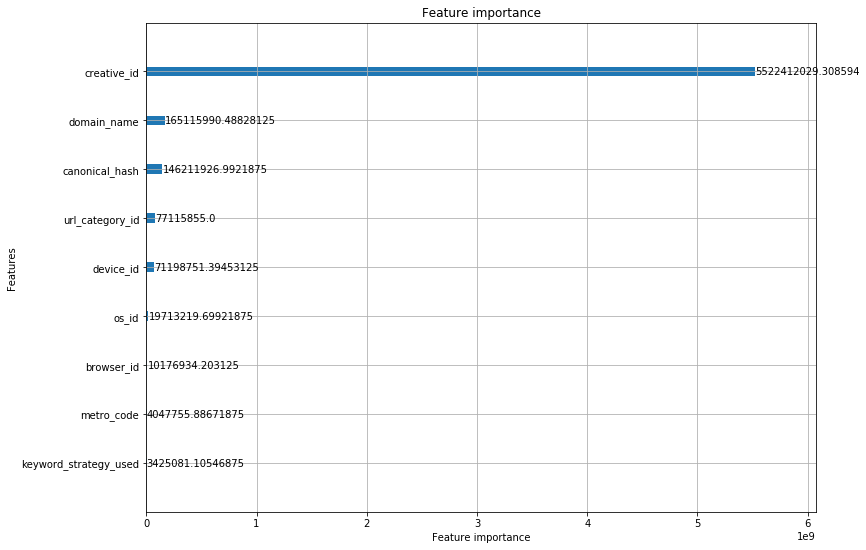

In [126]:
plot_feature_importance_lightgbm(lightgbm_model)

## Rank Mean

In [84]:
def rank_mean_util(df,col_list,rank_dict):
    col_set = set()
    
    i=1
    for col in col_list:
        rank_dict[col] = rank_dict[col]+i
        col_set.add(col)
        i +=1
        
    for col in get_features(df):
        if col not in col_set:
            rank_dict[col] +=i
    
    return rank_dict

In [85]:
def rank_mean(df,coeff_df_woe,coeff_col,imp_feature_list_xgboost,imp_feature_list_lightgbm):
    rank_dict = {}
    for col in get_features(df):
        rank_dict[col]=0
        
    rank_dict = rank_mean_util(df,list(coeff_df_woe[coeff_col]),rank_dict)
    rank_dict = rank_mean_util(df,imp_feature_list_xgboost,rank_dict)
    rank_dict = rank_mean_util(df,imp_feature_list_lightgbm,rank_dict)
    
    for col in rank_dict.keys():
        rank_dict[col] = rank_dict[col]/3
    
    sorted_by_rank = sorted(rank_dict.items(), key=lambda kv: kv[1])
    return [x[0] for x in sorted_by_rank]

In [130]:
ret_list = rank_mean(misced_df,coeff_df_woe,'col',imp_feature_list_xgboost,imp_feature_list_lightgbm)

In [131]:
def add_to_list(ret_list,columns=None):
    if columns is not None:
        return list(set(ret_list+columns))
    else:
        return ret_list

In [132]:
ret_list = ret_list[:5]

## Weight Plot

In [133]:
weight_plot(misced_df,ret_list,weight_col)

## Weight Plot(Target Based)

In [134]:
weight_plot_target(misced_df,ret_list,target_col,weight_col)

## Average Values Plot(Average Target)

In [135]:
average_value_plot(misced_df,ret_list,target_col,weight_col)

## Conditional Feature Importance(Next Candidate Feature)

In [92]:
from sklearn.metrics import log_loss

def conditional_feature_importance_util(df,target,weight,columns,model):
    train_df = df[columns]
    logloss_df = pd.DataFrame(columns=['Features','Logloss Reduction'])
    
    model.fit(train_df,target,sample_weight = weight)
    predicted_target = model.predict_proba(train_df)
    initial_logloss = log_loss(target,predicted_target,sample_weight = weight)
    
    for col in set(get_features(df))-set(columns):
        train_df[col] = df[col]
        
        model.fit(train_df,target,sample_weight=weight)
        predicted_target = model.predict_proba(train_df)
        
        logloss = log_loss(target,predicted_target,sample_weight = weight)
        logloss_df = logloss_df.append({'Features':col,'Logloss Reduction':initial_logloss-logloss},ignore_index=True)
        train_df.drop(col,axis=1,inplace=True)
        
    return logloss_df

In [93]:
def conditional_feature_importance(df,df_with_null,columns):
    df = make_copy_df(df)
    
    target = df[target_col]
    df.drop([target_col],axis=1,inplace=True)
    weight = df[weight_col]
    df.drop([weight_col],axis=1,inplace=True)
    
    model = LogisticRegression(penalty='l1',C=0.005,verbose=1)
    logloss_logistic = conditional_feature_importance_util(df,target,weight,columns,model)
    
    model = XGBClassifier(learning_rate=0.02,max_depth=5,n_estimators=50,booster='gbtree',silent=False,missing=None)
    logloss_xgboost = conditional_feature_importance_util(df_with_null,target,weight,columns,model)
    
    return (logloss_logistic,logloss_xgboost)

In [114]:
(logloss_logistic,logloss_xgboost) = conditional_feature_importance(woe_df,numerical_df,['creative_id'])

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

## Loss Reduction on addition of each feature

In [115]:
logloss_logistic = logloss_logistic.sort_values(by='Logloss Reduction',ascending=False)
logloss_logistic

,Features,Logloss Reduction
5,os_id,0.004480
7,device_id,0.002934
4,canonical_hash,0.002871
0,domain_name,0.001834
6,browser_id,0.001135
8,url_category_id,0.000500
2,partner_id,0.000275
10,keyword_strategy_used,0.000084
3,metro_code,0.000038
9,hour_id,0.000031


In [116]:
logloss_xgboost = logloss_xgboost.sort_values(by='Logloss Reduction',ascending=False)
logloss_xgboost

,Features,Logloss Reduction
7,device_id,0.006448
5,os_id,0.006382
4,canonical_hash,0.004885
0,domain_name,0.003178
10,keyword_strategy_used,0.002020
6,browser_id,0.001930
8,url_category_id,0.001563
2,partner_id,0.000810
1,country_code,0.000694
3,metro_code,0.000568


In [97]:
def cramers_bias_corrected(df,col1,col2,weight_col):
    confusion_matrix = pd.crosstab(df[col1], df[col2], df[weight_col], aggfunc=sum)
    confusion_matrix.fillna(0,inplace=True)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [98]:
def categorical_corr_df(df,weight_col,target_col=None):
    columns = get_categorical_cols()
    if(len(columns)==1):
        return
    
    if target_col is not None:
        corr = pd.DataFrame(index=columns,columns=[target_col])
        i=0
        while i<len(columns):
            corr.ix[columns[i]][target_col] = cramers_bias_corrected(df,columns[i],target_col,weight_col)
            i+=1
        corr.sort_values(by=target_col,ascending=False,inplace=True)
    else:
        corr = pd.DataFrame(index=columns,columns=columns)
        
        i=0
        while i<len(columns):
            j=i
            while j<len(columns):
                if i==j:
                    corr.ix[columns[i]][columns[j]] = 1
                else:
                    corr.ix[columns[j]][columns[i]] = cramers_bias_corrected(df,columns[i],columns[j],weight_col)
                    corr.ix[columns[i]][columns[j]] = corr.ix[columns[j]][columns[i]]
                j+=1
            i+=1
            
    return corr

In [99]:
cat_corr = categorical_corr_df(misced_df,weight_col)
cat_corr

,partner_id,domain_name,country_code,creative_id,canonical_hash,keyword_strategy_used,browser_id,device_id,os_id,metro_code,url_category_id,hour_id
partner_id,1,0.927814,0.337742,0.702084,0.7051,0.373828,0.247826,0.223235,0.231485,0.27565,0.543133,0.0973632
domain_name,0.927814,1,0.309304,0.743605,0.582663,0.750242,0.494976,0.62649,0.608285,0.194974,0.514603,0.133066
country_code,0.337742,0.309304,1,0.301068,0.5497,0.214116,0.145674,0.167185,0.191323,0.313303,0.213509,0.0959853
creative_id,0.702084,0.743605,0.301068,1,0.537003,0.719279,0.374116,0.449679,0.493571,0.158416,0.470068,0.125551
canonical_hash,0.7051,0.582663,0.5497,0.537003,1,0.550958,0.452359,0.562302,0.583738,0.162281,0.643017,0.164189
keyword_strategy_used,0.373828,0.750242,0.214116,0.719279,0.550958,1,0.376253,0.475651,0.496141,0.189333,0.458741,0.0809824
browser_id,0.247826,0.494976,0.145674,0.374116,0.452359,0.376253,1,0.676488,0.666232,0.303896,0.288105,0.057586
device_id,0.223235,0.62649,0.167185,0.449679,0.562302,0.475651,0.676488,1,0.645601,0.324842,0.404254,0.0554527
os_id,0.231485,0.608285,0.191323,0.493571,0.583738,0.496141,0.666232,0.645601,1,0.365449,0.377634,0.0787286
metro_code,0.27565,0.194974,0.313303,0.158416,0.162281,0.189333,0.303896,0.324842,0.365449,1,0.116722,0.0809273


In [100]:
def cov(df, col1, col2, weight_col):
    mean_col1 = weighted_mean(df,col1,weight_col)
    mean_col2 = weighted_mean(df,col2,weight_col)
    return ((df[weight_col]*((df[col1]-mean_col1)*(df[col2]-mean_col2))).sum())/get_total(df,weight_col)

def get_pearson_coeff(df,col1,col2,weight_col):
    num = cov(df,col1,col2,weight_col)
    std1 = weighted_std(df,[col1],weight_col)[0]
    std2 = weighted_std(df,[col2],weight_col)[0]
    den = std1*std2
    return num/den

In [101]:
def numerical_corr_df(df,weight_col,target_col=None):
    #Change the below line to get_numerical_columns
    columns = get_numerical_cols()
    if(len(columns)==1):
        return
    
    if target_col is not None:
        corr = pd.DataFrame(index=columns,columns=[target_col])
        i=0
        while i<len(columns):
            corr.ix[columns[i]][target_col] = get_pearson_coeff(df,columns[i],target_col,weight_col)
            i+=1
        corr.sort_values(by=target_col,ascending=False,inplace=True)
    else:
        corr = pd.DataFrame(index=columns,columns=columns)
    
        i=0
        while i<len(columns):
            j=i
            while j<len(columns):
                corr.ix[columns[j]][columns[i]] = get_pearson_coeff(df,columns[i],columns[j],weight_col)
                corr.ix[columns[i]][columns[j]] = corr.ix[columns[j]][columns[i]]
                j+=1
            i+=1
            
    return corr

In [102]:
num_corr = numerical_corr_df(misced_df,weight_col)
num_corr

""


In [103]:
#Correlation with Target
corr_target = categorical_corr_df(misced_df,weight_col,target_col)
corr_target

,visible_impression
creative_id,0.809997
domain_name,0.767974
canonical_hash,0.744703
url_category_id,0.663031
partner_id,0.462525
os_id,0.341411
keyword_strategy_used,0.337967
device_id,0.316855
country_code,0.310022
browser_id,0.247637


## Clustering Feature Values having similar target behaviour

In [107]:
def save_cluster(cluster_fig):
    cluster_fig.render(view=True)

In [108]:
def lightgbm_clustering(df,col,target_col,weight_col):
    target = df[target_col]
    weight = df[weight_col]
    
    train_df = pd.DataFrame(df[col])
    
    model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=14,
                               max_depth=4,learning_rate=1,objective='binary',n_estimators=1, max_cat_threshold = 1000)
    
    model.fit(train_df,target,sample_weight=weight,categorical_feature=col)
    
    return model

In [109]:
lightgbm_cluster = lightgbm_clustering(label_encoded_df,["hour_id"],target_col,weight_col)

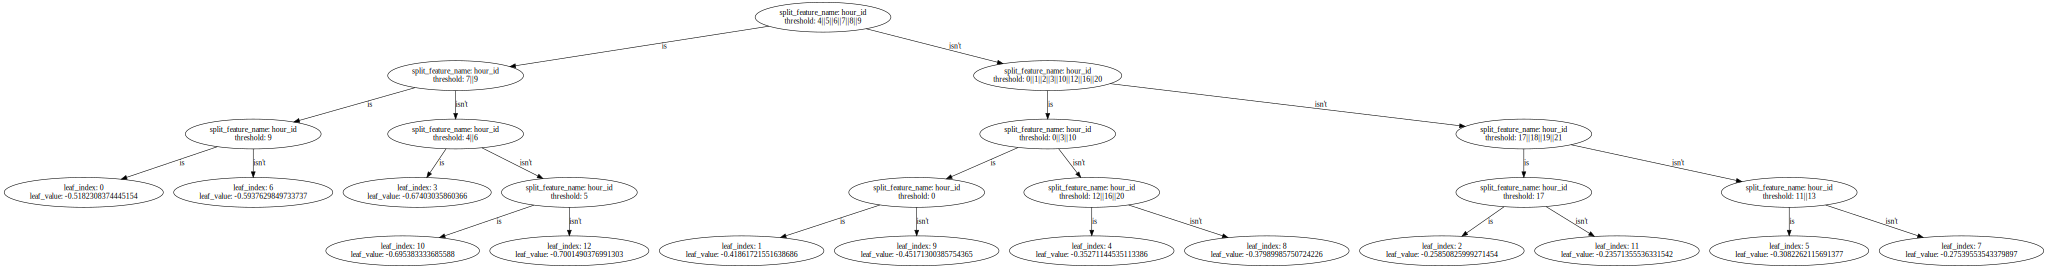

In [110]:
cluster_fig = lgb.create_tree_digraph(lightgbm_cluster,tree_index=0,filename='hour_tree',format='png')
save_cluster(cluster_fig)
cluster_fig